# Simple MCMC analysis (z-band)

## References

* HAT-P-14 b [(Fukui+16a))](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'moscatel'

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#import multiprocessing

df = pd.read_csv('g-band.csv', index_col=0, parse_dates=True)

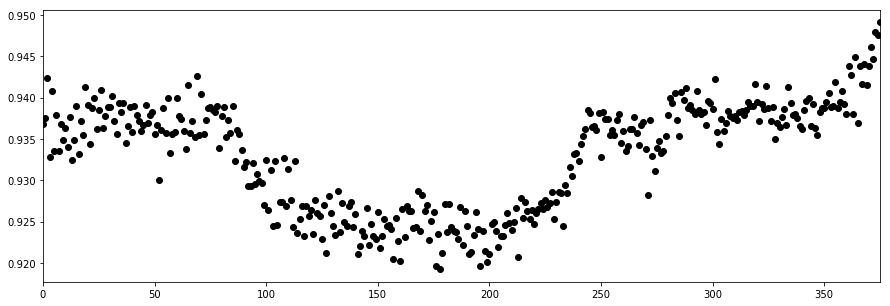

In [13]:
(df['z_b_flux'] / df['z_a_flux']).plot(figsize=(15,5), color='k', marker='o', linestyle='none')

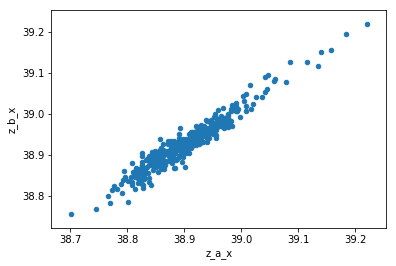

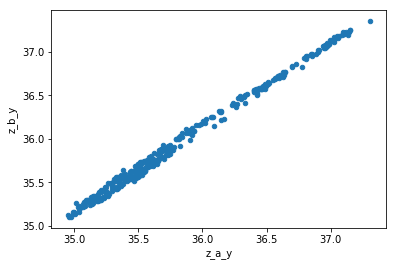

In [14]:
df.plot.scatter(*'z_a_x z_b_x'.split())
df.plot.scatter(*'z_a_y z_b_y'.split())

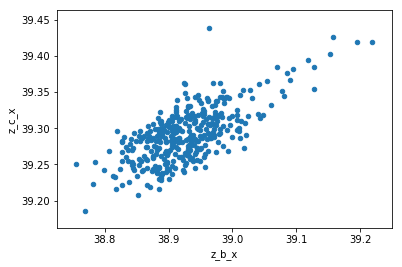

In [15]:
df.plot.scatter(*'z_b_x z_c_x'.split())

## Centroid

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f499bec1d90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f499bac7150>], dtype=object)

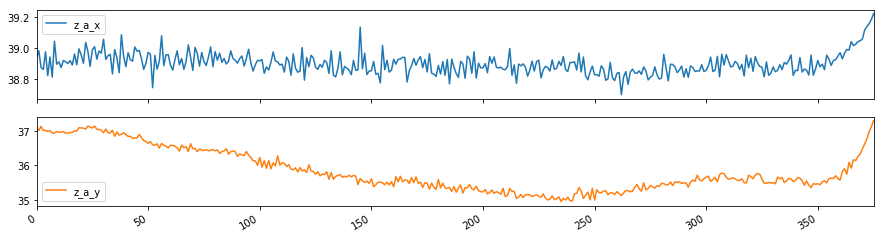

In [16]:
cols = 'z_a_x z_a_y'.split()
df[cols].plot(subplots=True, figsize=(15,4))

## FWHM

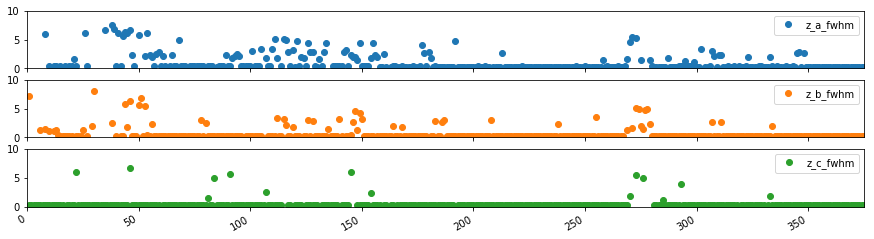

In [17]:
cols = 'z_a_fwhm z_b_fwhm z_c_fwhm'.split()
df[cols].plot(subplots=True, figsize=(15,4), ylim=(0,10), marker='o', linestyle='');

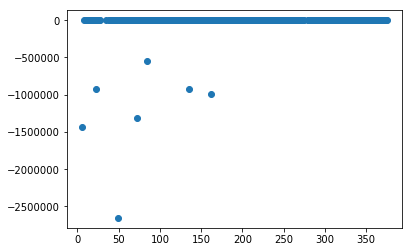

In [18]:
a = df['z_a_fwhm']
a_filtered = a[a<10] 
plt.plot(a_filtered, 'o')

## Relative photometry

In [19]:
f = (df['z_b_flux'] / df['z_a_flux']).values
f /= np.median(f)

In [28]:
t = df.index.to_julian_date().values

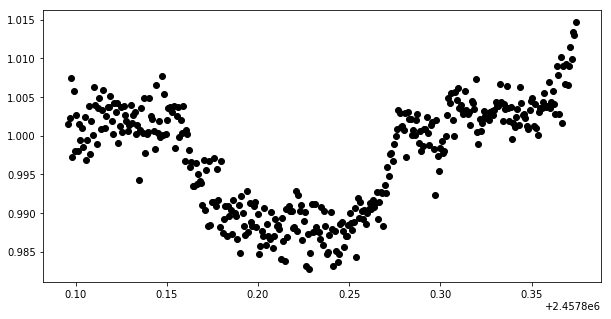

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(t, f, 'ko')

## MLE

In [30]:
def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

tc = t.mean()
p = 4.3
k = np.sqrt(0.015)
i = np.pi/2
t14 = 2.8/24
u1 = 0.4
u2 = 0.4
a = scaled_a(p, t14, k, i=np.pi/2)
# ls = np.log(f.std())
# k0 = 0
# theta = [k,tc,a,i,u1,u2,ls,k0]
theta = [k,tc,a,i,u1,u2]
print ("initial guess: {}".format(theta))

initial guess: [0.1224744871391589, 2457800.2350507793, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]


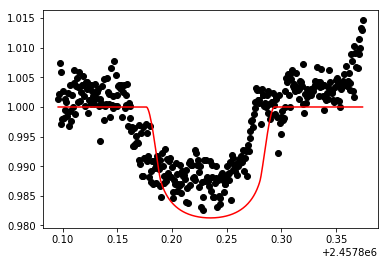

In [31]:
from pytransit import MandelAgol
MA = MandelAgol()

def model_u(theta, t, p):
    k,tc,a,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a, i)
    return m

plt.plot(t, f, 'ko', t, model_u(theta, t, p), 'r-')

In [32]:
import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

print ("cost before: {}".format(obj(theta, t, p, f)))
res = op.minimize(obj, theta, args=(t, p, f), method='nelder-mead')
print ("cost after: {}".format(obj(res.x, t, p, f)))

cost before: 0.0134922832405
cost after: 0.00731000110467


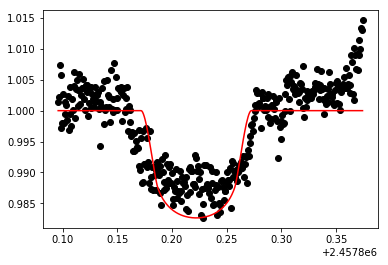

In [33]:
plt.plot(t, f, 'ko', t, model_u(res.x, t, p), 'r-')

In [34]:
xcenter = df['z_a_x']
ycenter = df['z_a_y']

#fwhm = xcenter*ycenter
fwhm = df['z_a_fwhm']

In [35]:
np.c_[fwhm, xcenter, ycenter].shape

(376, 3)

In [36]:
df['z_a_fwhm'].head()#.query('5<a<10')

2017-02-15 14:18:15.853140    5.092934e+05
2017-02-15 14:19:19.198086    8.252583e+05
2017-02-15 14:20:23.215785    5.485812e+05
2017-02-15 14:21:27.114902    2.070094e+06
2017-02-15 14:22:30.800449    1.384643e+06
Name: z_a_fwhm, dtype: float64

### Systematic Model

In [37]:
ls = np.log(f.std())
k0, k1, k2, k3, k4 = 0,0,0,0,0
theta = [k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4] #add sys params

def model_s(theta, fwhm, xcenter, ycenter, t):
    a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    dummy = np.ones(len(fwhm))
    s = (np.array(theta)*np.c_[fwhm, xcenter, ycenter, t, dummy]).sum(axis=1)
    return s

def loglike(theta, t, f, p, fwhm, xcenter, ycenter, ret_mod=False, ret_sys=False, ret_full = False):
    ls = theta[6]
    m = model_u(theta[:6], t, p)
    s = model_s(theta[7:], fwhm, xcenter, ycenter, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

nll = lambda *x: -loglike(*x)

print ("NLL before: {}".format(nll(theta, t, f, p, fwhm, xcenter, ycenter)))
res = op.minimize(nll, theta, args=(t, f, p, fwhm, xcenter, ycenter), method='powell')
print ("NLL after: {}".format(nll(res.x, t, f, p, fwhm, xcenter, ycenter)))

NLL before: -1727.47607745
NLL after: -1674.06769735


In [38]:
%timeit model_s(range(5), fwhm, xcenter, ycenter, t)

The slowest run took 4.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 141 µs per loop


In [39]:
%timeit model_u(theta[:6], t, p)

The slowest run took 34.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 186 µs per loop


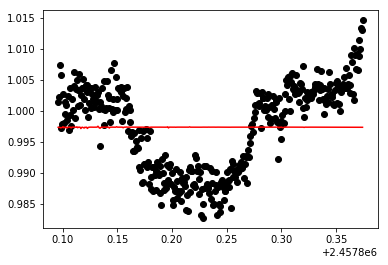

In [40]:
plt.plot(t, f, 'ko', t, loglike(res.x, t, f, p, fwhm, xcenter, ycenter, ret_full=True), 'r-')

## Maximum A Priori Estimation

In [41]:
def logprob(theta, t, f, p, fwhm, xcenter, ycenter, up=None):

    k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4 = theta

    if u1 < 0 or u1 > 2 or u2 < -1 or u2 > 1 or k < 0 or k > 1 or i > np.pi/2:
        return -np.inf

    lp = 0
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    ll = loglike(theta, t, f, p, fwhm, xcenter, ycenter)

    if np.isnan(ll).any():
        return -np.inf
    
    return lp + ll


nlp = lambda *x: -logprob(*x)

print ("NLP before: {}".format(nlp(theta, t, f, p, fwhm, xcenter, ycenter)))
res = op.minimize(nlp, theta, args=(t, p, f, fwhm, xcenter, ycenter), method='nelder-mead')
print ("NLP after: {}".format(nlp(res.x, t, f, p, fwhm, xcenter, ycenter)))

NLP before: -1727.47607745
NLP after: 336454663.473


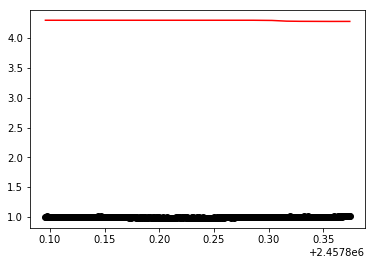

In [42]:
plt.plot(t, f, 'ko', t, loglike(res.x, t, f, p, fwhm, xcenter, ycenter, ret_full=True), 'r-')

## MCMC

In [45]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p, fwhm, xcenter, ycenter
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)

pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

0it [00:00, ?it/s]/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
1000it [03:14,  6.11it/s]


## Parameter best estimates

In [46]:
for i,j in zip(theta, sampler.flatchain.mean(axis=0)): 
    print(i,j)

(0.1224744871391589, 0.11237320963543102)
(2457800.2350507793, 2457800.2219128031)
(13.18482235546915, 12.07280607868373)
(1.5707963267948966, 1.5552533587652888)
(0.4, 0.40754840161910982)
(0.4, 0.3791425000805036)
(-4.9569299324982135, -5.5712440399074818)
(0, -1.7921152425936482e-07)
(0, 0.012814096700347331)
(0, -6.0733950188086351e-05)
(0, -5.5649808922711255e-07)
(0, 0.21983884956648539)


In [47]:
sampler.flatlnprobability.shape

(192000,)

In [48]:
sampler.flatchain.shape

(192000, 12)

In [49]:
sampler.flatlnprobability.max()

2063.1375811368898

In [50]:
max_idx=np.argmax(sampler.flatlnprobability)

In [51]:
#parameter vector
pv=sampler.flatchain[max_idx]
pv

array([  1.06390900e-01,   2.45780022e+06,   1.18417237e+01,
         1.56245953e+00,   4.57018350e-01,   3.83353414e-01,
        -5.98773139e+00,  -6.06430136e-10,   1.78068681e-02,
         6.86470520e-05,  -5.98591876e-06,   1.40195466e+01])

## Modelling results

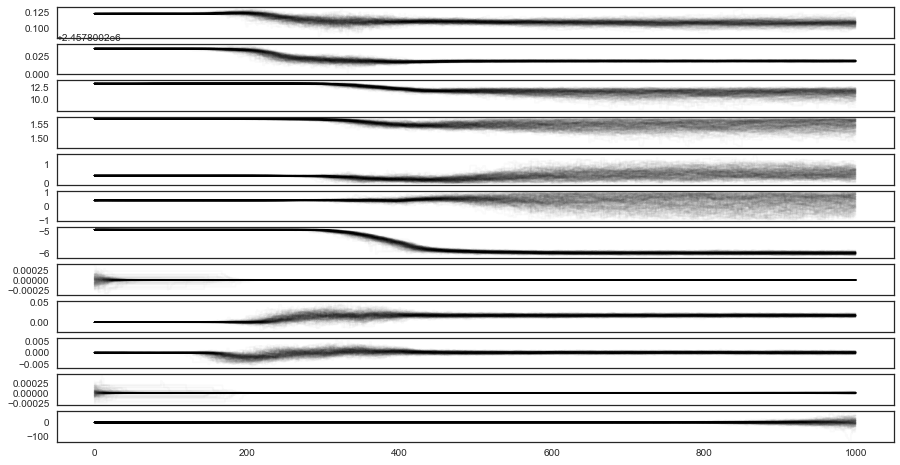

In [52]:
import seaborn as sb

chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    ax.set_ylim()

Monitor the [Gelman-Rubin statistic]() to ensure high quality posterior samples for the chains produced by the MCMC sampler 

* stabilize below a typical value of at most 1.03 up to a maximum of N steps for each of the N walkers
* cull the final chain using the burn-in value of N and thinning by a factor of 10 to account for autocorrelation in samples
* the final flattened chains thus consist of approximately X independent posterior samples

In [53]:
burn = 500

In [54]:
#nwalkers, nsteps, ndim
sampler.chain.shape

(192, 1000, 12)

In [55]:
sampler.chain[:,burn:,:].shape

(192, 500, 12)

In [56]:
sampler.chain[:,burn:,:].reshape(-1, ndim).shape

(96000, 12)

In [57]:
fc=sampler.chain[:,burn:,:].reshape(-1, ndim)

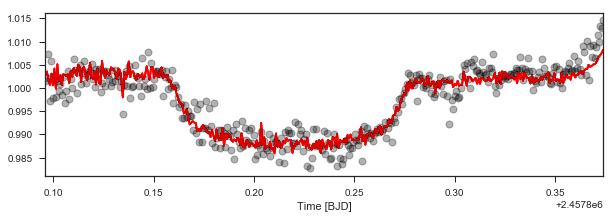

In [58]:
ps = [loglike(pv, t, f, p, fwhm, xcenter, ycenter, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

with sb.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        ax.plot(t, s, 'r-', alpha=0.03)
    plt.setp(ax, xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))

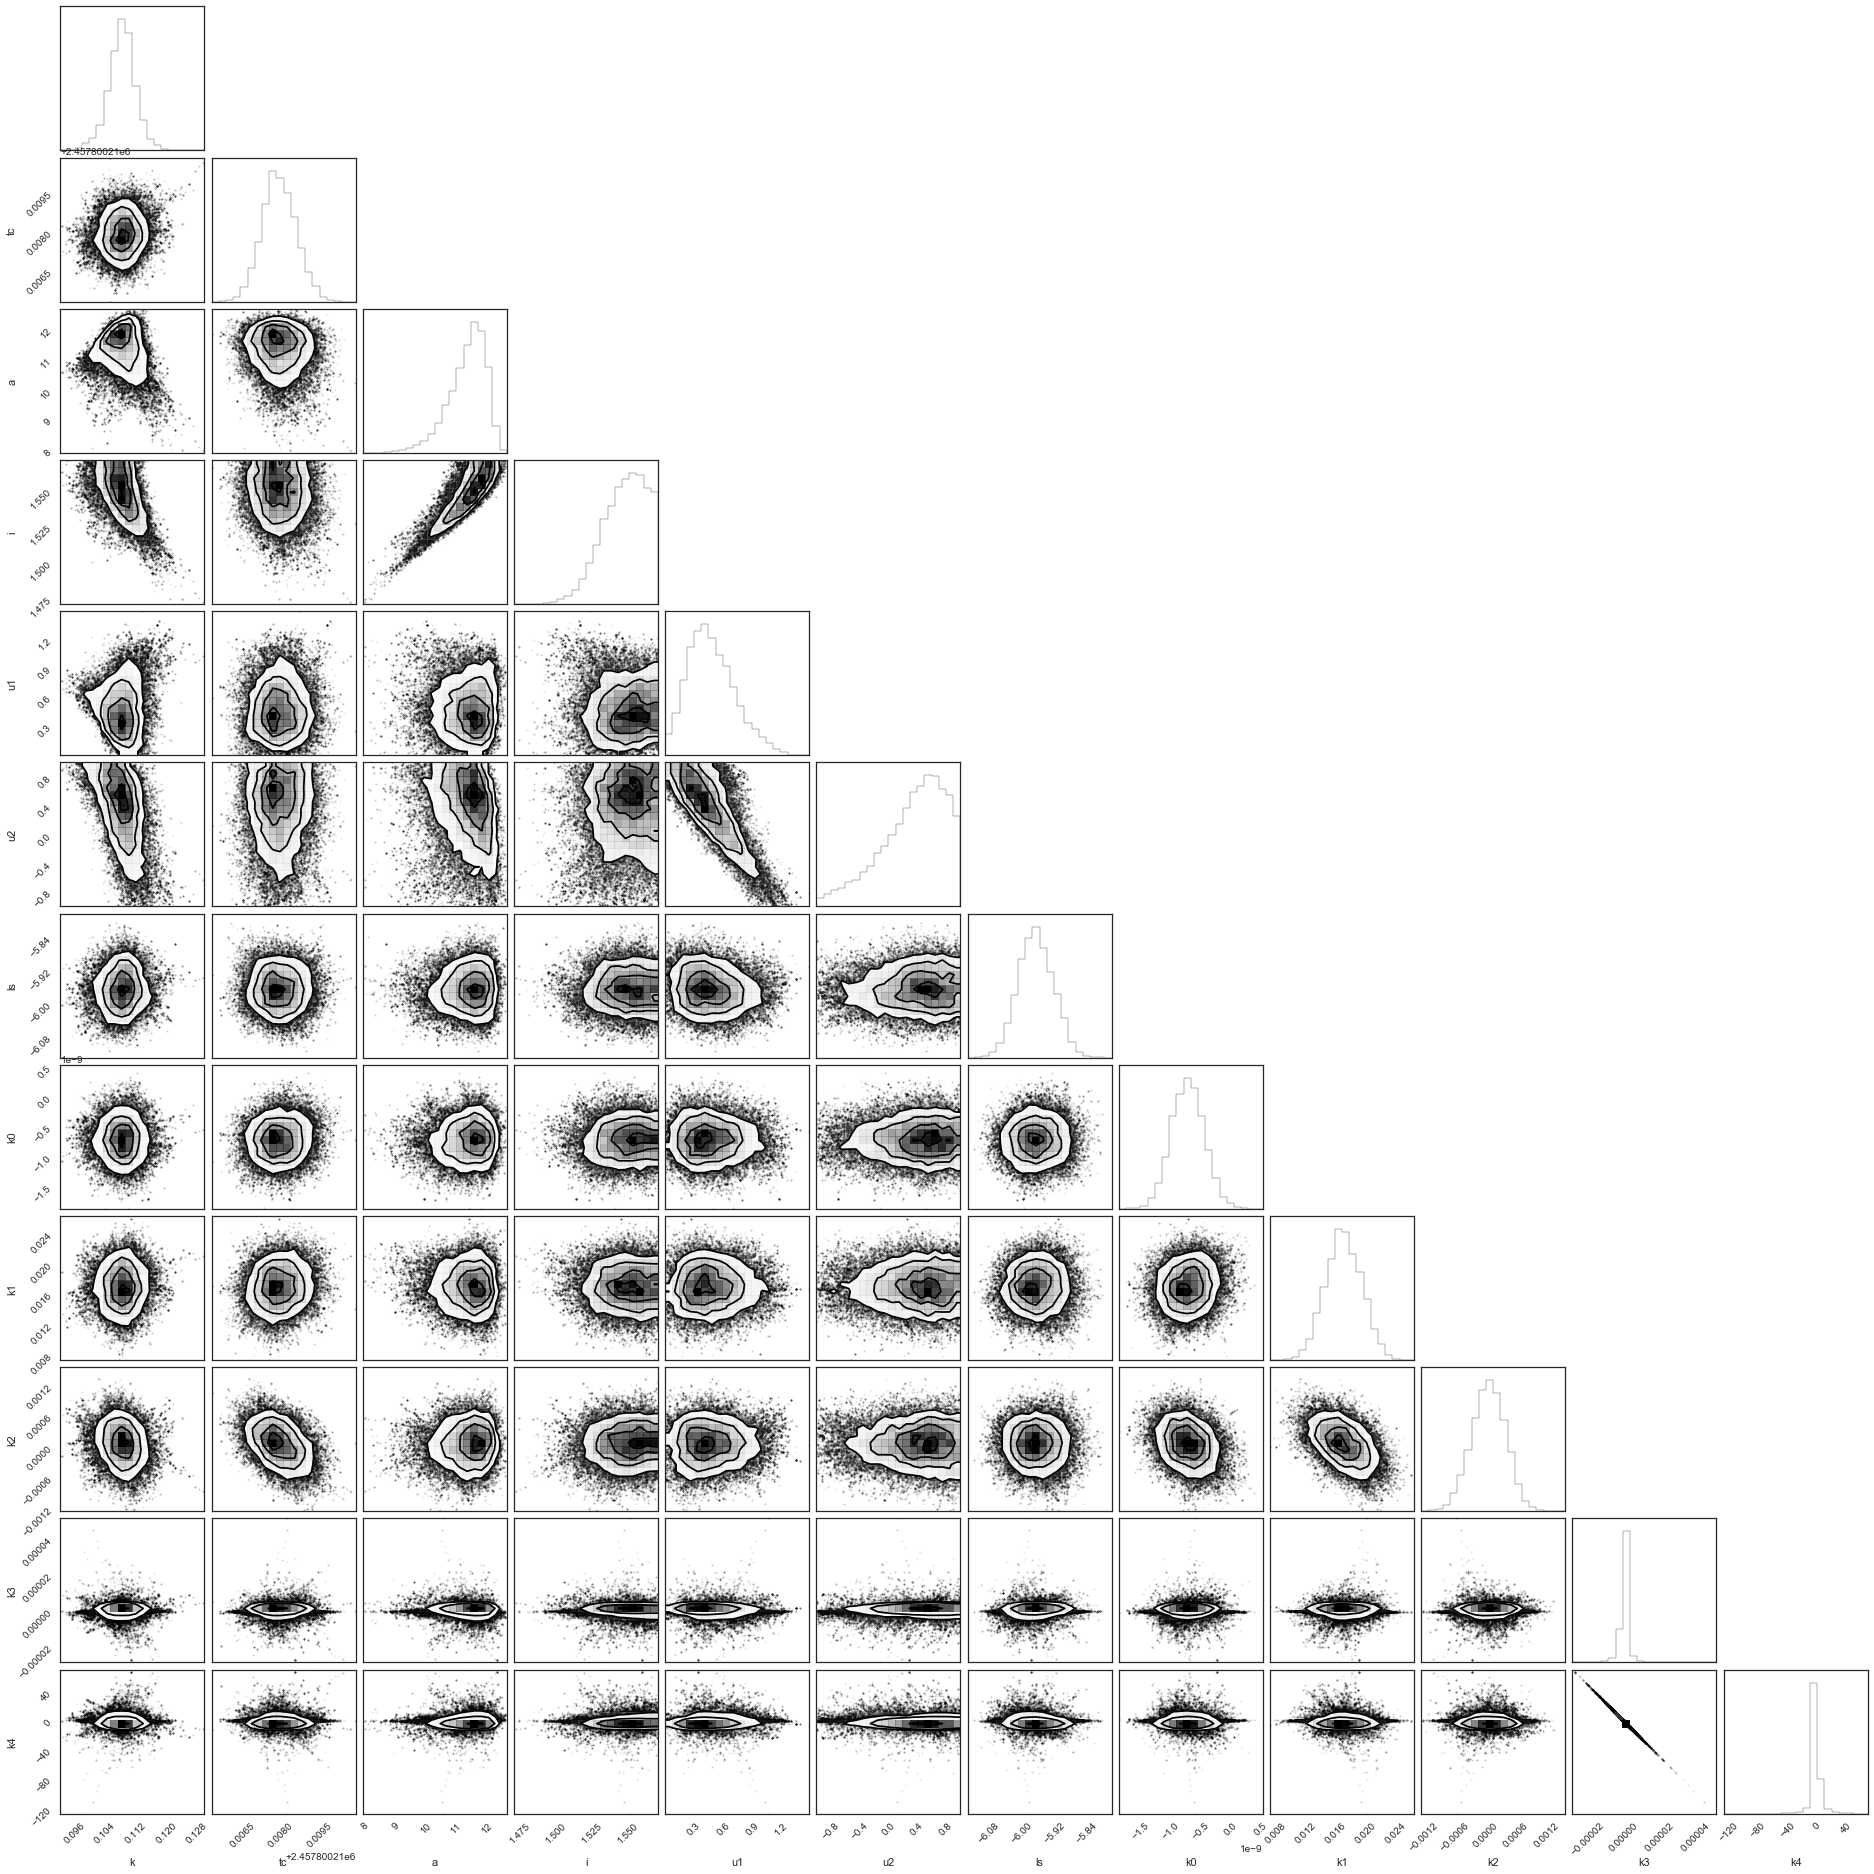

In [60]:
import corner
with sb.axes_style('white'):
    corner.corner(fc, labels='k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4'.split(','))

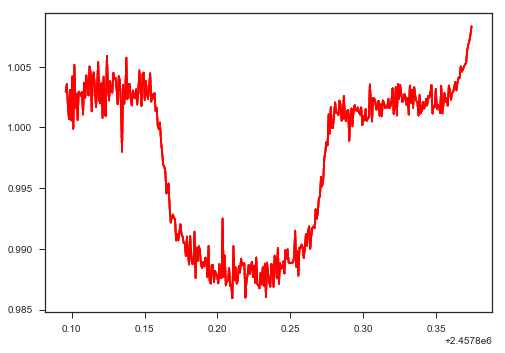

In [61]:
import seaborn as sb
#modeling+systematics
with sb.axes_style('ticks'):
    for s in ps:
        plt.plot(t, s, 'r-', alpha=0.03)

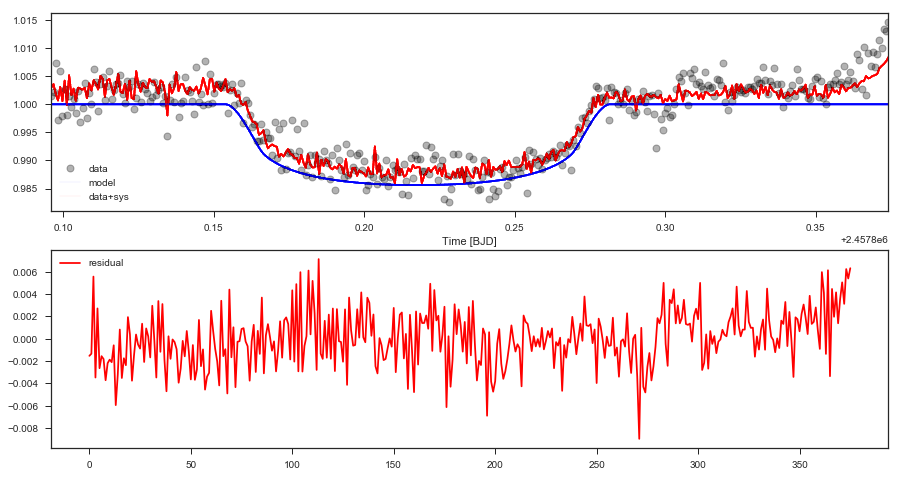

In [62]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(2, 1, figsize=(15,8))
    #data
    ax[0].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        #model
        ax[0].plot(t, loglike(pv, t, f, p, fwhm, xcenter, ycenter, ret_mod=True), 
                   'b-', alpha=0.03) 
        #model+systematics
        ax[0].plot(t, s, 'r-', alpha=0.03)
    #residual
    res = loglike(pv, t, f, p, fwhm, xcenter, ycenter, ret_full=True)
    ax[1].plot(f-res, 'r-', label='residual')
    plt.setp(ax[0], xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))
ax[0].legend(['data','model','data+sys'], loc='lower left')
ax[1].legend(loc='best')

## residual autocorrelation

* to check for randomness in time series
* compute autocorrelations for data values at varying time lags
* if data is random, autocorr should be near zero for any and all time-lag separations
* if non-random, significantly non-zero
* horizontal lines below correspond to 95% and 99% confidence bands
* dashed line is 99% confidence band

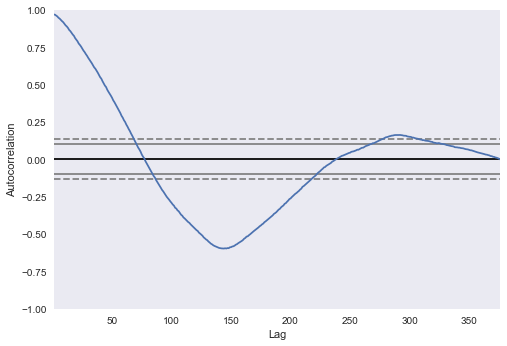

In [64]:
from pandas.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(res)